<a href="https://colab.research.google.com/github/TastyButSadly/ClimateNet/blob/main/HSE_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import os
from matplotlib import cm, colors
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import shutil
from google.colab import files

In [2]:
data_daily = pd.read_csv('/content/daily_avg.csv', index_col=0)
data_hour = pd.read_csv('/content/hour_data.csv', index_col=0)
data_monthly = pd.read_csv('/content/monthly_avg.csv', index_col=0)

In [3]:
city_map = {
    0: 'Москва',
    1: 'Санкт-Петербург',
    2: 'Нижний Новгород',
    3: 'Казань',
    4: 'Уфа',
    5: 'Новосибирск',
    6: 'Владивосток'
}

In [4]:
def get_season(date):
    m = date.month
    if m in [12, 1, 2]:
        return 'winter'
    elif m in [3, 4, 5]:
        return 'spring'
    elif m in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

In [5]:
def prepare_df(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col])
    df['season'] = df[date_col].apply(get_season)
    return df

In [6]:
data_daily = prepare_df(data_daily, 'date')
data_hour = prepare_df(data_hour, 'time')
data_monthly = prepare_df(data_monthly, 'date')

In [7]:
def draw_graph_with_strength_magma(G, title='', city_map=None, show_weights=True):

    pos = nx.spring_layout(G, seed=42, k=5)

    weights = [abs(G[u][v]['weight']) for u, v in G.edges()]
    norm = colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = plt.get_cmap('magma')

    fig, ax = plt.subplots(figsize=(12, 6))

    nx.draw_networkx_nodes(G, pos, node_size=1300, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)

    for (u, v) in G.edges():
        w = abs(G[u][v]['weight'])
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            width=3,
            edge_color=[cmap(norm(w))],
            ax=ax
        )

    if show_weights:
        edge_labels = nx.get_edge_attributes(G, 'weight')
        edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax=ax)

    if city_map:
        legend_text = "\n".join([f"{i}: {city_map[i]}" for i in sorted(city_map.keys())])
        bbox_props = dict(boxstyle="round,pad=0.5", fc="lightgrey", ec="black", lw=1)

        fig.text(0.02, 0.02, legend_text, fontsize=11, va='bottom', ha='left', bbox=bbox_props)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Корреляция', fontsize=11)

    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
def build_correlation_graph(df, season, method='pearson', threshold=0.7):
    df_season = df[df['season'] == season]
    temp_pivot = df_season.pivot_table(
        index='date',
        columns='location_id',
        values='daily_avg_temp' if 'daily_avg_temp' in df.columns else 'temperature'
    )

    corr_matrix = temp_pivot.corr(method=method)

    G = nx.Graph()
    locations = corr_matrix.columns.tolist()
    G.add_nodes_from(locations)

    for i in range(len(locations)):
        for j in range(i+1, len(locations)):
            corr = corr_matrix.iloc[i, j]
            if abs(corr) >= threshold:
                G.add_edge(locations[i], locations[j], weight=corr)

    return G, corr_matrix

In [11]:
G_daily_winter_pearson, matrix = build_correlation_graph(data_daily, 'winter', method='pearson', threshold=0.5)

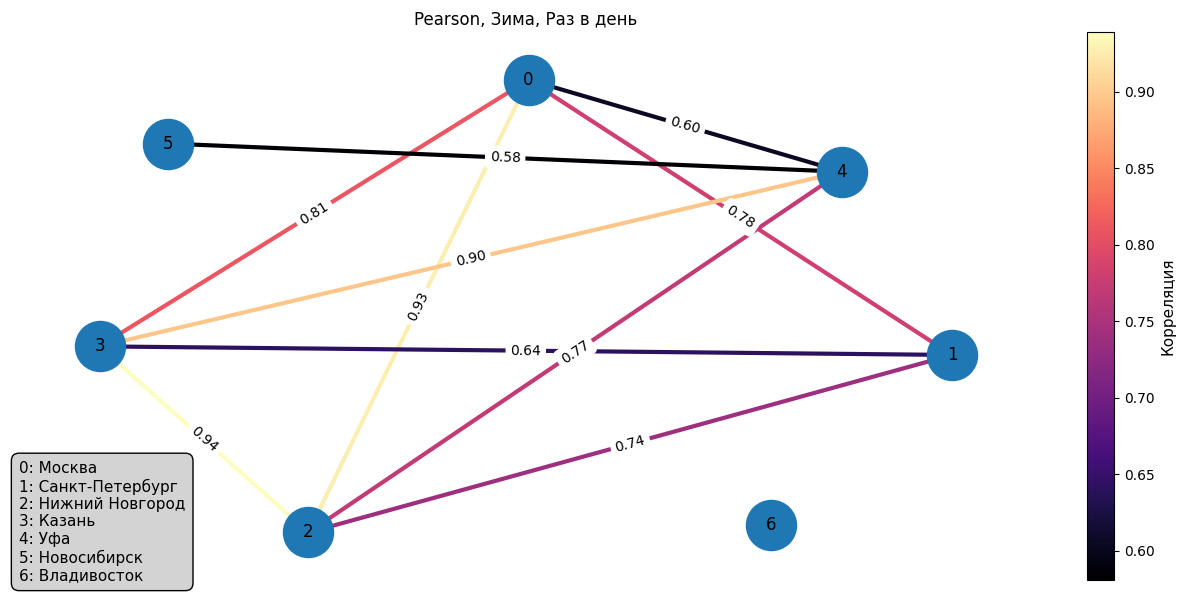

In [12]:
draw_graph_with_strength_magma(G_daily_winter_pearson, title='Pearson, Зима, Раз в день', city_map=city_map)

In [13]:
season_titles = {
    'winter': 'зима',
    'spring': 'весна',
    'summer': 'лето',
    'autumn': 'осень'
}

frequencies = {
    'hour': (data_hour, 'раз в час'),
    'daily': (data_daily, 'раз в день'),
    'monthly': (data_monthly, 'раз в месяц'),
}

thresholds = [i/10 for i in range(1, 10)]
methods = ['pearson', 'kendall']
seasons = list(season_titles.keys())

In [14]:
def build_correlation_graph(df, season, method='pearson', threshold=0.7):
    df_season = df[df['season'] == season]
    date_col = 'date' if 'date' in df.columns else 'time'

    if 'daily_avg_temp' in df.columns:
        temp_col = 'daily_avg_temp'
    elif 'temperature' in df.columns:
        temp_col = 'temperature'
    elif 'monthly_avg_temp' in df.columns:
        temp_col = 'monthly_avg_temp'
    else:
        raise ValueError("no t column")

    temp_pivot = df_season.pivot_table(
        index=date_col,
        columns='location_id',
        values=temp_col
    )

    corr_matrix = temp_pivot.corr(method=method)

    G = nx.Graph()
    locations = corr_matrix.columns.tolist()
    G.add_nodes_from(locations)

    for i in range(len(locations)):
        for j in range(i + 1, len(locations)):
            corr = corr_matrix.iloc[i, j]
            if abs(corr) >= threshold:
                G.add_edge(locations[i], locations[j], weight=corr)

    return G, corr_matrix

def save_graph(G, title, path, city_map=None):
    os.makedirs(os.path.dirname(path), exist_ok=True)

    pos = nx.spring_layout(G, seed=42, k=5)
    weights = [abs(G[u][v]['weight']) for u, v in G.edges()]
    norm = colors.Normalize(vmin=0, vmax=1)
    cmap = plt.get_cmap('magma')

    fig, ax = plt.subplots(figsize=(12, 6))
    nx.draw_networkx_nodes(G, pos, node_size=1300, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)

    for (u, v) in G.edges():
        w = abs(G[u][v]['weight'])
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            width=3,
            edge_color=[cmap(norm(w))],
            ax=ax
        )

    edge_labels = nx.get_edge_attributes(G, 'weight')
    edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax=ax)

    if city_map:
        legend_text = "\n".join([f"{i}: {city_map[i]}" for i in sorted(city_map.keys())])
        bbox_props = dict(boxstyle="round,pad=0.5", fc="lightgrey", ec="black", lw=1)
        fig.text(0.02, 0.02, legend_text, fontsize=11, va='bottom', ha='left', bbox=bbox_props)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Корреляция', fontsize=11)

    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(path)
    plt.close()


def task_generate_graph(args):
    df, season, freq_key, freq_title, threshold, method, city_map, mode = args
    season_ru = season_titles[season]
    G, _ = build_correlation_graph(df, season, method=method, threshold=threshold)
    title = f'{method.title()}, {season_ru}, {freq_title}'

    if mode == 'by_frequency':
        path = f'graphs/{method}/{threshold}/by_frequency/{freq_key}_{season}.png'
    else:
        path = f'graphs/{method}/{threshold}/by_season/{season}_{freq_key}.png'

    save_graph(G, title, path, city_map)
    return path

In [15]:
tasks = []

for method in methods:
    for threshold in thresholds:
        for freq_key, (df, freq_title) in frequencies.items():
            for season in seasons:
                tasks.append((df, season, freq_key, freq_title, threshold, method, city_map, 'by_frequency'))

        for season in seasons:
            for freq_key, (df, freq_title) in frequencies.items():
                tasks.append((df, season, freq_key, freq_title, threshold, method, city_map, 'by_season'))

num_workers = min(multiprocessing.cpu_count(), 8)

with ProcessPoolExecutor(max_workers=num_workers) as executor:
    results = list(executor.map(task_generate_graph, tasks))

print(f"Сохранено {len(results)} графов")

Сохранено 432 графов


In [16]:
shutil.make_archive('/content/graphs', 'zip', '/content/graphs')
files.download('/content/graphs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>